In [1]:
# Import necessary libraries
import os
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from torch.optim import Adam
import torch.nn.functional as F

# Set up project paths
def setup_paths():
    cwd = os.getcwd()
    project_root = os.path.abspath(os.path.join(cwd, ".."))
    src_path = os.path.join(project_root, "src")
    if src_path not in sys.path:
        sys.path.append(src_path)

setup_paths()

In [2]:
# Import VAE models and utilities
from model import MNISTVariationalAutoEncoder, CIFAR10VariationalAutoEncoder
from utils import m2_loss_labeled, validate,m2_loss_unlabeled,smooth_ELBO_labeled,smooth_ELBO_unlabeled

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
## Function to load dataset
def load_dataset(dataset_name):
    if dataset_name == "MNIST":
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])
        dataset = datasets.MNIST(root="../data", train=True, transform=transform, download=True)
        test_dataset = datasets.MNIST(root="../data", train=False, transform=transform, download=True)
        model = MNISTVariationalAutoEncoder(latent_dim=128, num_classes=10).to(device)
    else:
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        dataset = datasets.CIFAR10(root="../data", train=True, transform=transform, download=True)
        test_dataset = datasets.CIFAR10(root="../data", train=False, transform=transform, download=True)
        model = CIFAR10VariationalAutoEncoder(latent_dim=128, num_classes=10).to(device)

    return dataset, test_dataset, model

In [4]:
# Function to train the model on labeled data only
def train_labeled(model, loader, optimizer, criterion, num_epochs=30):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()

            # Labeled data loss
            y_onehot = F.one_hot(y, model.num_classes).float().to(device)
            recon, mean, log_var, logits = model(x, y_onehot=y_onehot)
            loss = criterion(recon, x, mean, log_var, logits, y)

            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Labeled Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss:.4f}")

In [5]:
# Function to train the model on the full dataset (labeled + unlabeled)
def train_unlabeled(model, labeled_loader, unlabeled_loader, optimizer, criterion_labeled, criterion_unlabeled, num_epochs=30):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for (x_labeled, y_labeled), (x_unlabeled, _) in zip(labeled_loader, unlabeled_loader):
            x_labeled, y_labeled = x_labeled.to(device), y_labeled.to(device)
            x_unlabeled = x_unlabeled.to(device)

            optimizer.zero_grad()

            # Labeled data loss
           # y_onehot = F.one_hot(y_labeled, model.num_classes).float().to(device)
            #recon_labeled, mean_l, log_var_l, logits_l = model(x_labeled, y_onehot=y_onehot)
           # loss_labeled = criterion_labeled(recon_labeled, x_labeled, mean_l, log_var_l, logits_l, y_labeled)

            # Unlabeled data loss
            recon_unlabeled, mean_u, log_var_u, logits_u = model(x_unlabeled)
            loss_unlabeled = criterion_unlabeled(recon_unlabeled, x_unlabeled, mean_u, log_var_u, logits_u)

            # Combine losses
            loss =  loss_unlabeled
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Full Dataset Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss:.4f}")

In [6]:
# Function to save the trained model
def save_model(model, path):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    torch.save(model.state_dict(), path)
    print(f"Model saved to: {path}")

# Function to load the trained model
def load_model(model, path):
    if os.path.exists(path):
        model.load_state_dict(torch.load(path, map_location=device))
        print(f"Model loaded successfully from {path}")
    else:
        raise FileNotFoundError(f"Checkpoint not found at {path}. Ensure the model is trained and saved.")
    return model

In [7]:
# Function to extract logits and images
def extract_logits_and_images(model, data_loader):
    model.eval()
    logits_list, labels_list, images_list = [], [], []
    with torch.no_grad():
        for x, y in data_loader:
            x = x.to(device)
            _, _, _, logits = model(x)
            logits_list.append(logits.cpu().numpy())
            labels_list.append(y.numpy())
            images_list.append(x.cpu().numpy())
    return np.concatenate(logits_list), np.concatenate(labels_list), np.concatenate(images_list)

In [8]:
# Visualization functions
def plot_logits_and_images(images, logits, labels, dataset_name, num_samples=5):
    softmax_logits = torch.softmax(torch.tensor(logits), dim=1).numpy()
    sample_indices = np.random.choice(len(logits), num_samples, replace=False)
    plt.figure(figsize=(15, 8))
    for i, idx in enumerate(sample_indices):
        plt.subplot(2, num_samples, i + 1)
        img = images[idx]
        if dataset_name == "MNIST":
            plt.imshow(img.squeeze(), cmap="gray")
        else:
            img = np.transpose(img, (1, 2, 0))
            plt.imshow((img - img.min()) / (img.max() - img.min()))
        plt.axis("off")
        plt.title(f"Label: {labels[idx]}")
        plt.subplot(2, num_samples, num_samples + i + 1)
        plt.bar(range(len(softmax_logits[idx])), softmax_logits[idx])
        plt.title("Softmax of Logits")
        plt.xlabel("Class")
        plt.ylabel("Probability")
    plt.tight_layout()
    plt.show()

In [9]:
def visualize_latent_space(logits, labels, method="PCA"):
    if method == "PCA":
        reducer = PCA(n_components=2)
    elif method == "TSNE":
        reducer = TSNE(n_components=2, random_state=42)
    else:
        raise ValueError("Invalid method. Choose 'PCA' or 'TSNE'.")
    reduced_latents = reducer.fit_transform(logits)
    plt.figure(figsize=(8, 8))
    scatter = plt.scatter(reduced_latents[:, 0], reduced_latents[:, 1], c=labels, cmap='tab10', alpha=0.7)
    plt.colorbar(scatter, label='Class Label')
    plt.title(f"Latent Space Visualization ({method})")
    plt.xlabel(f"{method} Component 1")
    plt.ylabel(f"{method} Component 2")
    plt.show()

In [10]:
dataset_name = "MNIST"  # Change to "CIFAR10" for CIFAR-10
dataset, test_dataset, vae_model = load_dataset(dataset_name)
num_epochs=50
# Split dataset for labeled and unlabeled training
labeled_size = int(len(dataset) * 0.1)
unlabeled_size = len(dataset) - labeled_size
labeled_data, unlabeled_data = random_split(dataset, [labeled_size, unlabeled_size])
labeled_loader = DataLoader(labeled_data, batch_size=128, shuffle=True)
unlabeled_loader = DataLoader(unlabeled_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

# Train on labeled data only
optimizer = Adam(vae_model.parameters(), lr=1e-3)
train_labeled(vae_model, labeled_loader, optimizer, m2_loss_labeled, num_epochs=50)
save_model(vae_model, "../trained_models/m2_labeled_only.pth")

# Train on the full dataset (labeled + unlabeled)
vae_model.load_state_dict(torch.load("../trained_models/m2_labeled_only.pth", map_location=device))
train_unlabeled(vae_model, labeled_loader, unlabeled_loader, optimizer, m2_loss_labeled, m2_loss_unlabeled, num_epochs=50)
save_model(vae_model, "../trained_models/m2_unlabeled.pth")

Labeled Epoch 1/50, Loss: 12691.2178
Labeled Epoch 2/50, Loss: 9784.7449
Labeled Epoch 3/50, Loss: 7783.9366
Labeled Epoch 4/50, Loss: 6486.5687
Labeled Epoch 5/50, Loss: 5843.5459
Labeled Epoch 6/50, Loss: 5367.0370
Labeled Epoch 7/50, Loss: 4953.0802
Labeled Epoch 8/50, Loss: 4660.7679
Labeled Epoch 9/50, Loss: 4407.3810
Labeled Epoch 10/50, Loss: 4204.6570
Labeled Epoch 11/50, Loss: 4045.8165
Labeled Epoch 12/50, Loss: 3901.6545
Labeled Epoch 13/50, Loss: 3791.2228
Labeled Epoch 14/50, Loss: 3686.5505
Labeled Epoch 15/50, Loss: 3618.2806
Labeled Epoch 16/50, Loss: 3548.7541
Labeled Epoch 17/50, Loss: 3487.5338
Labeled Epoch 18/50, Loss: 3445.2385
Labeled Epoch 19/50, Loss: 3401.9286
Labeled Epoch 20/50, Loss: 3365.9954
Labeled Epoch 21/50, Loss: 3330.0064
Labeled Epoch 22/50, Loss: 3286.3606
Labeled Epoch 23/50, Loss: 3258.5803
Labeled Epoch 24/50, Loss: 3239.8035
Labeled Epoch 25/50, Loss: 3218.3724
Labeled Epoch 26/50, Loss: 3192.7568
Labeled Epoch 27/50, Loss: 3147.3929
Labeled E

/tmp/ipykernel_7061/4164246745.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae_model.load_state_dict(torch.load("../trained_models/m2_labeled_only.pth", map_locatio

Full Dataset Epoch 1/50, Loss: 3233.5237
Full Dataset Epoch 2/50, Loss: 3180.9185
Full Dataset Epoch 3/50, Loss: 3137.2139
Full Dataset Epoch 4/50, Loss: 3099.7133
Full Dataset Epoch 5/50, Loss: 3080.6930
Full Dataset Epoch 6/50, Loss: 3068.2433
Full Dataset Epoch 7/50, Loss: 3053.8840
Full Dataset Epoch 8/50, Loss: 3027.7661
Full Dataset Epoch 9/50, Loss: 3024.5532
Full Dataset Epoch 10/50, Loss: 3020.6558
Full Dataset Epoch 11/50, Loss: 3017.5102
Full Dataset Epoch 12/50, Loss: 3033.2144
Full Dataset Epoch 13/50, Loss: 2985.1383
Full Dataset Epoch 14/50, Loss: 3011.2447
Full Dataset Epoch 15/50, Loss: 2997.3304
Full Dataset Epoch 16/50, Loss: 3004.0596
Full Dataset Epoch 17/50, Loss: 3003.8126
Full Dataset Epoch 18/50, Loss: 2952.5375
Full Dataset Epoch 19/50, Loss: 2957.6081
Full Dataset Epoch 20/50, Loss: 2960.5940
Full Dataset Epoch 21/50, Loss: 2950.1502
Full Dataset Epoch 22/50, Loss: 2935.8468
Full Dataset Epoch 23/50, Loss: 2949.9006
Full Dataset Epoch 24/50, Loss: 2928.0910
F

/tmp/ipykernel_7061/320379291.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path, map_location=device))


Model loaded successfully from ../trained_models/m2_labeled_only.pth


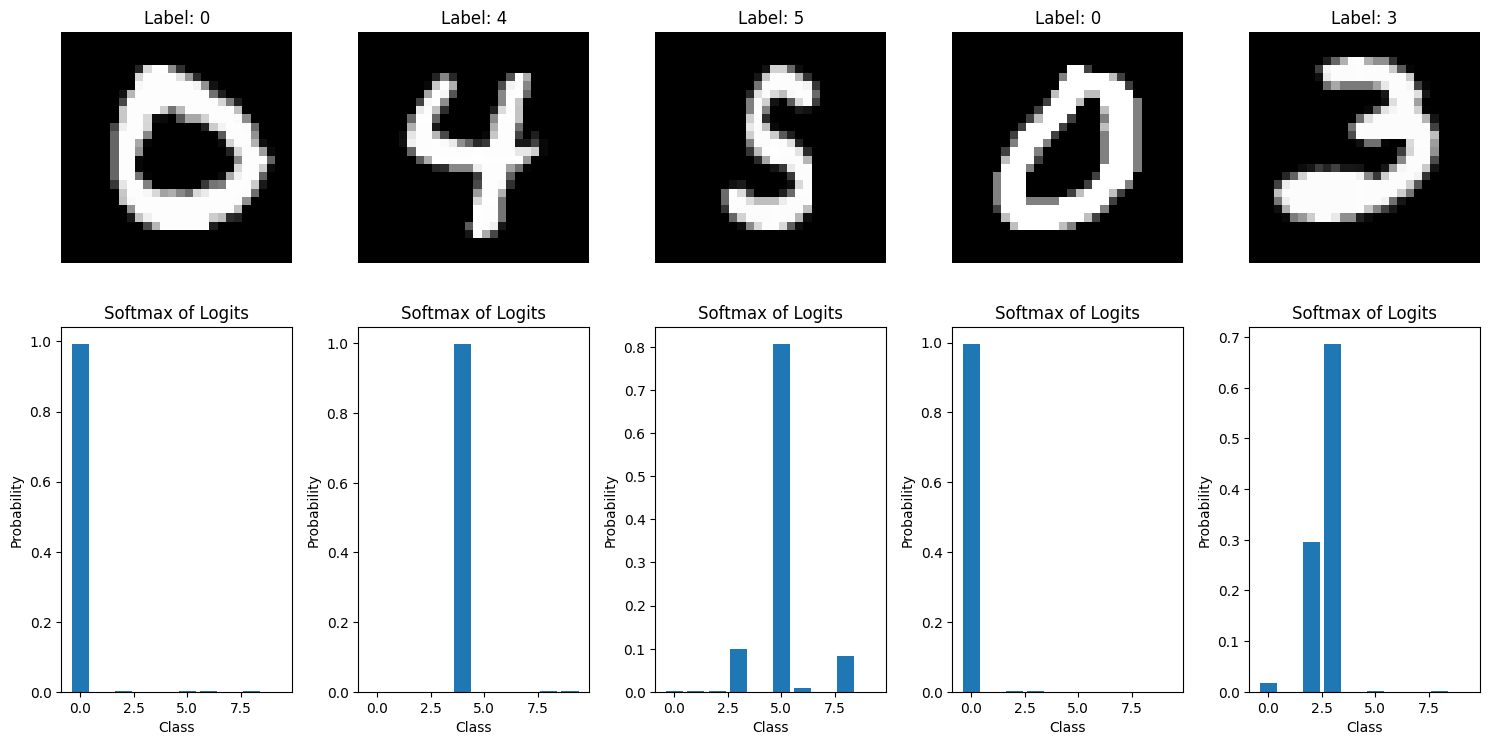

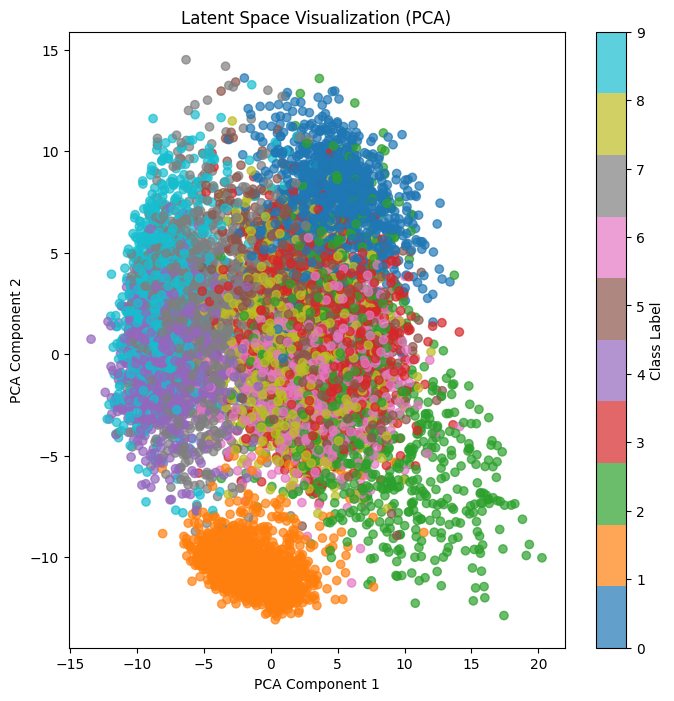

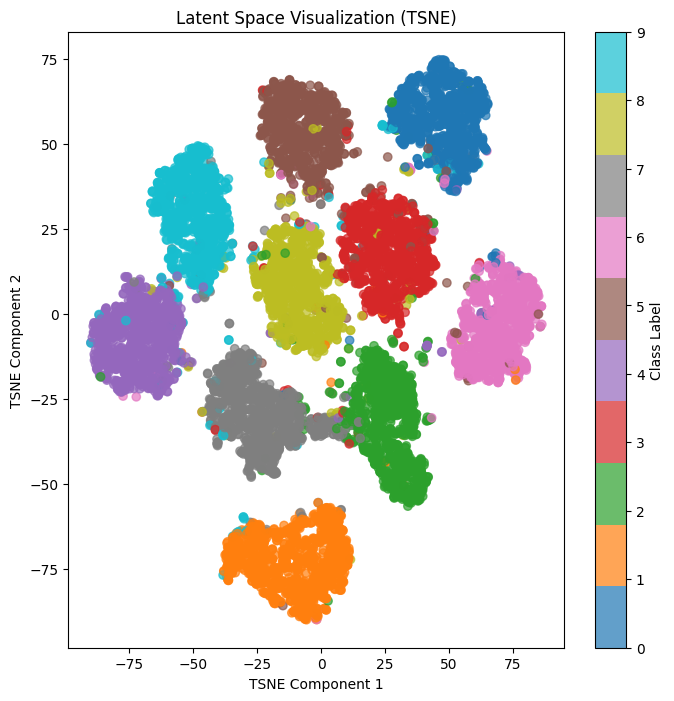

In [11]:
# Load model and analyze logits
vae_model = load_model(vae_model, "../trained_models/m2_labeled_only.pth")
logits, labels, images = extract_logits_and_images(vae_model, test_loader)
plot_logits_and_images(images, logits, labels, dataset_name)
visualize_latent_space(logits, labels, method="PCA")
visualize_latent_space(logits, labels, method="TSNE")

/tmp/ipykernel_7061/320379291.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path, map_location=device))


Model loaded successfully from ../trained_models//m2_unlabeled.pth


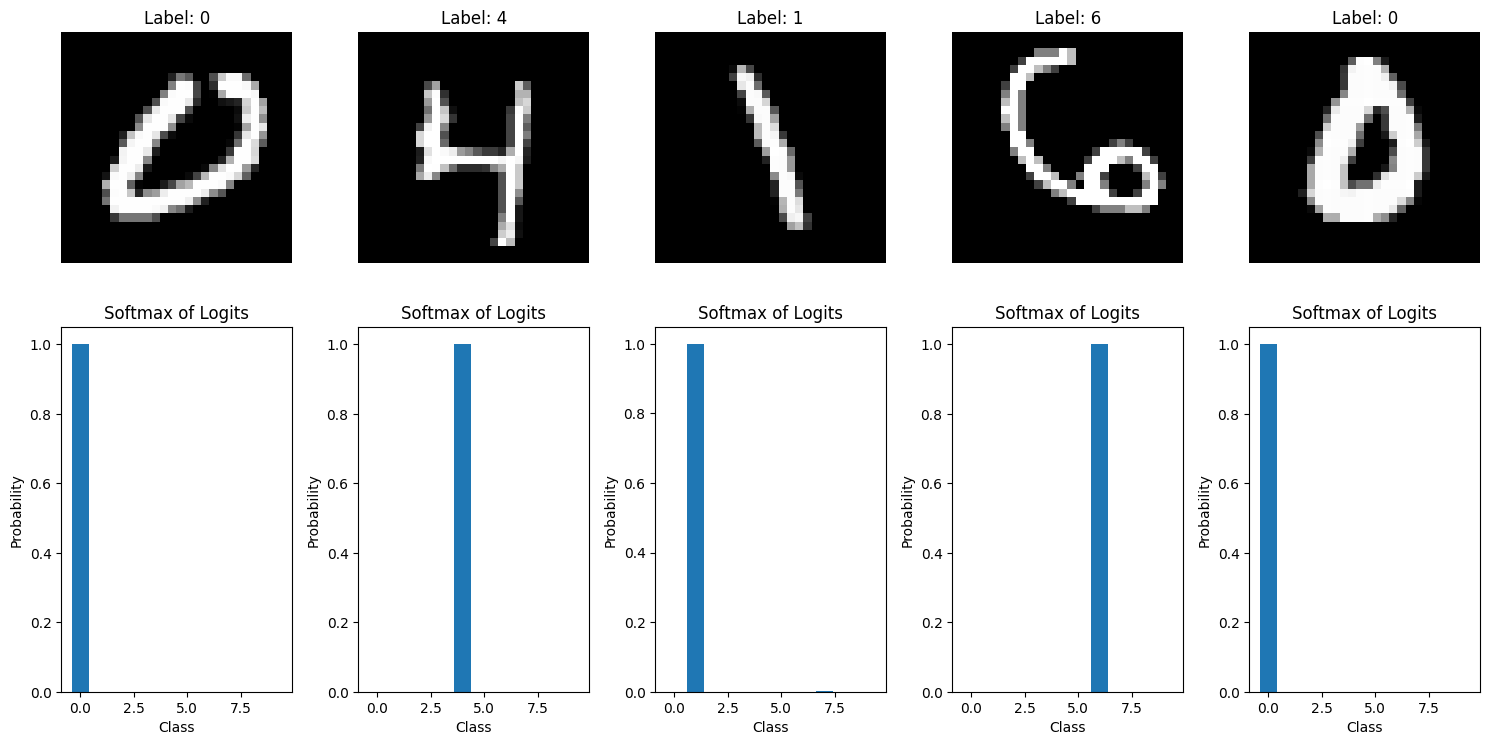

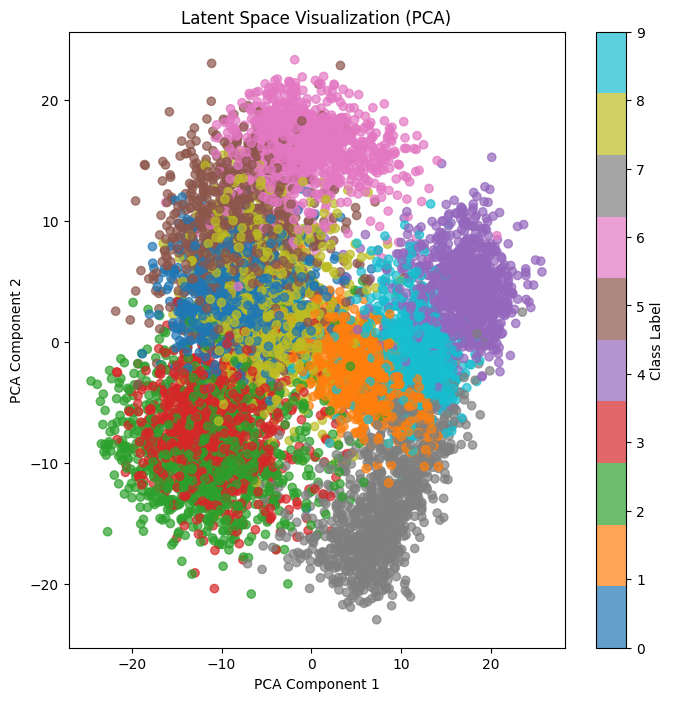

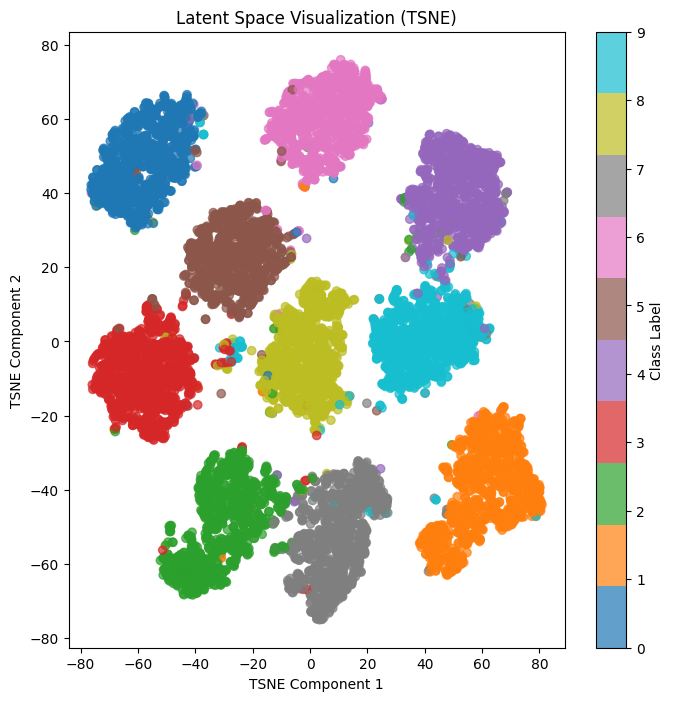

In [12]:
# Load model and analyze logits
vae_model = load_model(vae_model, "../trained_models//m2_unlabeled.pth")
logits, labels, images = extract_logits_and_images(vae_model, test_loader)
plot_logits_and_images(images, logits, labels, dataset_name)
visualize_latent_space(logits, labels, method="PCA")
visualize_latent_space(logits, labels, method="TSNE")

In [13]:
train_labeled(vae_model, labeled_loader, optimizer, smooth_ELBO_labeled, num_epochs=50)
save_model(vae_model, "../trained_models/smooth_ELBO_labeled_only.pth")

# Train on the full dataset (labeled + unlabeled)
vae_model.load_state_dict(torch.load("../trained_models/smooth_ELBO_labeled_only.pth", map_location=device))
train_unlabeled(vae_model, labeled_loader, unlabeled_loader, optimizer, smooth_ELBO_labeled, smooth_ELBO_unlabeled, num_epochs=50)
save_model(vae_model, "../trained_models/smooth_ELBO_unlabeled.pth")

Labeled Epoch 1/50, Loss: 2867.1406
Labeled Epoch 2/50, Loss: 2797.9749
Labeled Epoch 3/50, Loss: 2775.8070
Labeled Epoch 4/50, Loss: 2753.0807
Labeled Epoch 5/50, Loss: 2728.3876
Labeled Epoch 6/50, Loss: 2734.9105
Labeled Epoch 7/50, Loss: 2715.9545
Labeled Epoch 8/50, Loss: 2705.3096
Labeled Epoch 9/50, Loss: 2689.6373
Labeled Epoch 10/50, Loss: 2694.8448
Labeled Epoch 11/50, Loss: 2676.6617
Labeled Epoch 12/50, Loss: 2660.0943
Labeled Epoch 13/50, Loss: 2667.1960
Labeled Epoch 14/50, Loss: 2662.3156
Labeled Epoch 15/50, Loss: 2660.5532
Labeled Epoch 16/50, Loss: 2639.2607
Labeled Epoch 17/50, Loss: 2635.9160
Labeled Epoch 18/50, Loss: 2636.7049
Labeled Epoch 19/50, Loss: 2628.8178
Labeled Epoch 20/50, Loss: 2624.0333
Labeled Epoch 21/50, Loss: 2617.6132
Labeled Epoch 22/50, Loss: 2627.6415
Labeled Epoch 23/50, Loss: 2608.9673
Labeled Epoch 24/50, Loss: 2618.9801
Labeled Epoch 25/50, Loss: 2604.4685
Labeled Epoch 26/50, Loss: 2595.8686
Labeled Epoch 27/50, Loss: 2594.4376
Labeled Ep

/tmp/ipykernel_7061/3453707703.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae_model.load_state_dict(torch.load("../trained_models/smooth_ELBO_labeled_only.pth", map

Full Dataset Epoch 1/50, Loss: 2957.9743
Full Dataset Epoch 2/50, Loss: 2940.6002
Full Dataset Epoch 3/50, Loss: 2887.4606
Full Dataset Epoch 4/50, Loss: 2862.0755
Full Dataset Epoch 5/50, Loss: 2863.9544
Full Dataset Epoch 6/50, Loss: 2839.1498
Full Dataset Epoch 7/50, Loss: 2816.2478
Full Dataset Epoch 8/50, Loss: 2839.7691
Full Dataset Epoch 9/50, Loss: 2835.8006
Full Dataset Epoch 10/50, Loss: 2811.2420
Full Dataset Epoch 11/50, Loss: 2803.2663
Full Dataset Epoch 12/50, Loss: 2785.0996
Full Dataset Epoch 13/50, Loss: 2780.4296
Full Dataset Epoch 14/50, Loss: 2803.2858
Full Dataset Epoch 15/50, Loss: 2768.5016
Full Dataset Epoch 16/50, Loss: 2771.8318
Full Dataset Epoch 17/50, Loss: 2766.5519
Full Dataset Epoch 18/50, Loss: 2761.9086
Full Dataset Epoch 19/50, Loss: 2776.2600
Full Dataset Epoch 20/50, Loss: 2755.2980
Full Dataset Epoch 21/50, Loss: 2759.8453
Full Dataset Epoch 22/50, Loss: 2744.1126
Full Dataset Epoch 23/50, Loss: 2750.5185
Full Dataset Epoch 24/50, Loss: 2769.0839
F

/tmp/ipykernel_7061/320379291.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path, map_location=device))


Model loaded successfully from ../trained_models/smooth_ELBO_labeled_only.pth


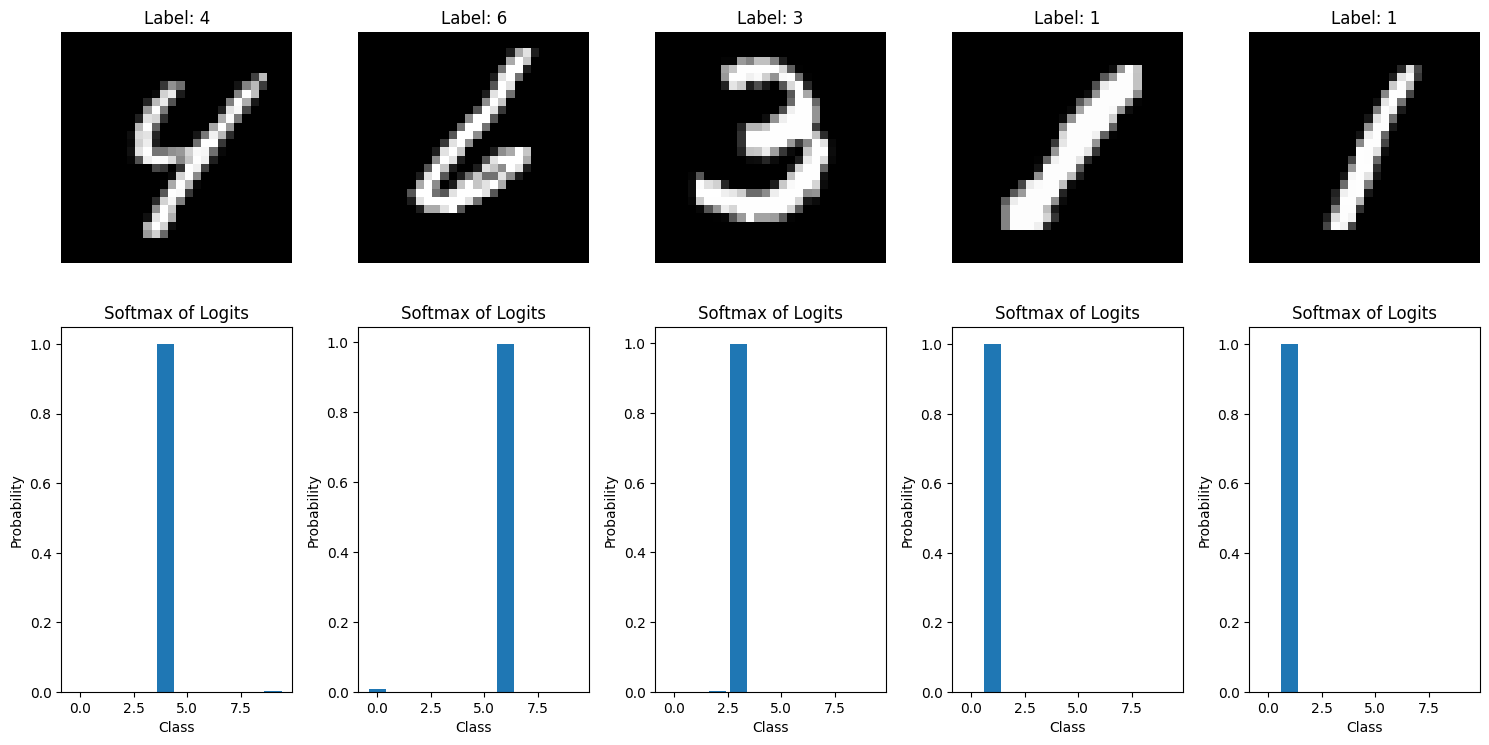

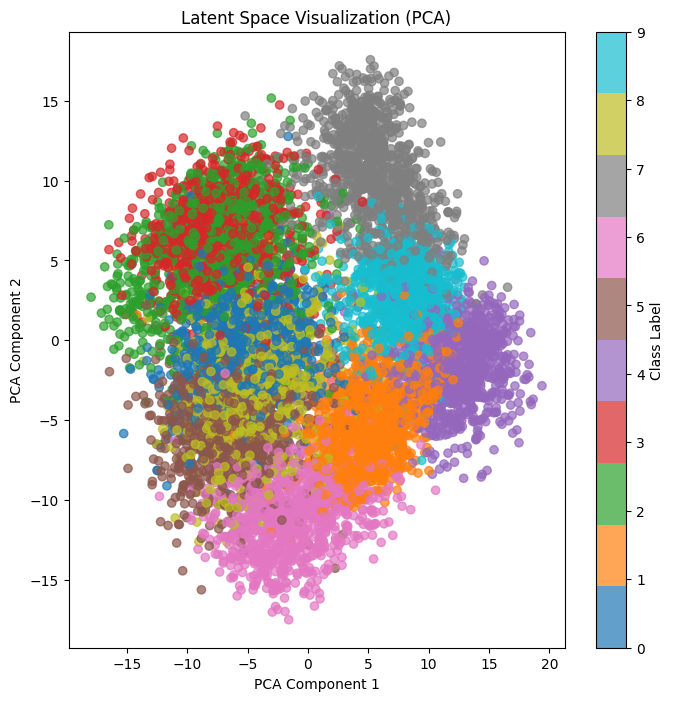

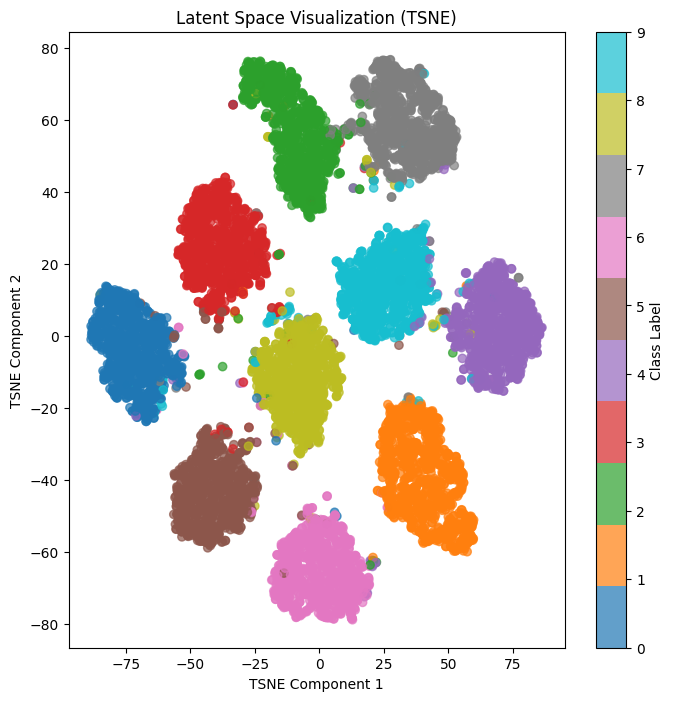

In [14]:
# Load model and analyze logits
vae_model = load_model(vae_model, "../trained_models/smooth_ELBO_labeled_only.pth")
logits, labels, images = extract_logits_and_images(vae_model, test_loader)
plot_logits_and_images(images, logits, labels, dataset_name)
visualize_latent_space(logits, labels, method="PCA")
visualize_latent_space(logits, labels, method="TSNE")

/tmp/ipykernel_7061/320379291.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path, map_location=device))


Model loaded successfully from ../trained_models//smooth_ELBO_unlabeled.pth


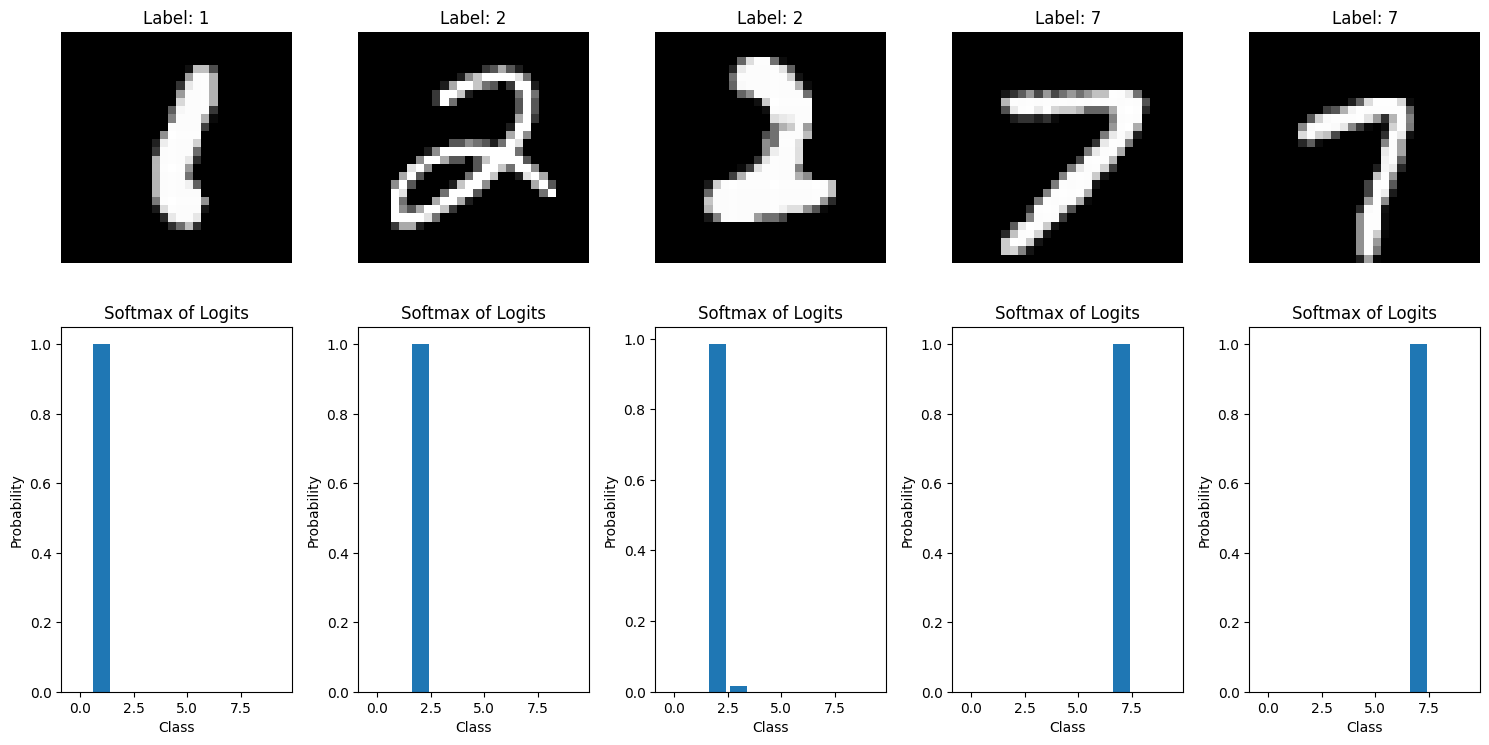

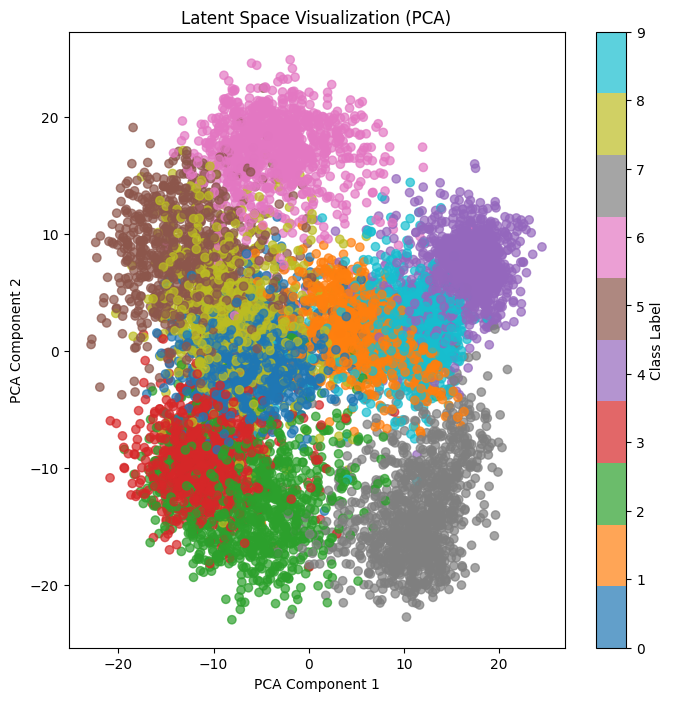

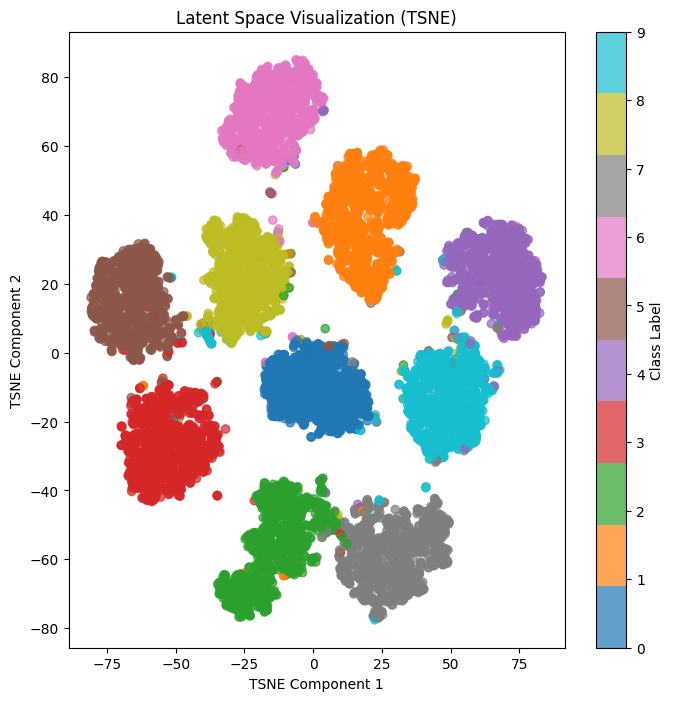

In [15]:
# Load model and analyze logits
vae_model = load_model(vae_model, "../trained_models//smooth_ELBO_unlabeled.pth")
logits, labels, images = extract_logits_and_images(vae_model, test_loader)
plot_logits_and_images(images, logits, labels, dataset_name)
visualize_latent_space(logits, labels, method="PCA")
visualize_latent_space(logits, labels, method="TSNE")